#Installing and Loading Dependencies

In [ ]:
!pip install tensorflow tensorflow-io matplotlib

  Using cached tensorflow-2.8.0-cp310-cp310-win_amd64.whl (438.0 MB)


In [ ]:
import os
from matplotlib import pyplot as plt
import tensorflow as tf 

#makes it easier to process our audio and to convert them 
import tensorflow_io as tfio

# 2. Specifying paths and reducing size

## 2.1 Specifying the files path

In [ ]:
CAPUCHIN_FILE = os.path.join('data', 'Parsed_Capuchinbird_Clips', 'XC3776-3.wav')
NOT_CAPUCHIN_FILE = os.path.join('data', 'Parsed_Not_Capuchinbird_Clips', 'afternoon-birds-song-in-forest-0.wav')

## 2.2 16 Khz conversion for less computataion

In [ ]:
def convert_16khz_single_channel(filepath):
    
    # Loading the encoded wav file, it returns a string format of our audio file
    file_contents = tf.io.read_file(filepath)
    # we need to decode our wave of strings
    wave, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    # we squeeze the array into an 1 channel or 1 column of values
    wave = tf.squeeze(wave, axis=-1)
    
    #convert it to integer so that we can sample the rate
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    
    # Converting 44100Hz to 16000hz, will require less computation
    wave = tfio.audio.resample(wave, rate_in=sample_rate, rate_out=16000)
    return wave

## 2.3 Plotting Wave of bird sound (converted 16khz) 

In [ ]:
bird = convert_16khz_single_channel(CAPUCHIN_FILE)
nobird = convert_16khz_single_channel(NOT_CAPUCHIN_FILE)

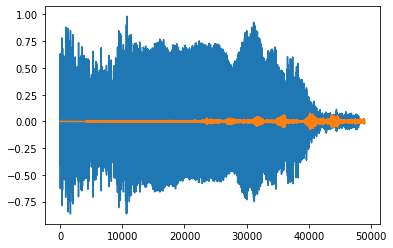

In [ ]:
plt.plot(bird)
plt.plot(nobird)
plt.show()

# 3. Preparing the Tensorflow Dataset

## 3.1 Defining paths to Bird and Non-Bird sounds 

In [ ]:
positive = os.path.join('data', 'Parsed_Capuchinbird_Clips')
negative = os.path.join('data', 'Parsed_Not_Capuchinbird_Clips')

In [ ]:
#gives set of files into strings,a tensorflow format that we can use tensorflow
pos = tf.data.Dataset.list_files(positive+'\*.wav') #looking for files ending with wav
neg = tf.data.Dataset.list_files(negative+'\*.wav')

In [ ]:
pos.as_numpy_iterator().next() #string file

b'data\\Parsed_Capuchinbird_Clips\\XC216012-9.wav'

## 3.2 Add labels 0-1 to the samples

In [ ]:
#concatenate files of positive path into an tensor of 1's and negatives into an tensor of 0's labels
positives = tf.data.Dataset.zip((pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
negatives = tf.data.Dataset.zip((neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))
data = positives.concatenate(negatives)

In [ ]:
positives.as_numpy_iterator().next() #we got 1's for each positive file
negatives.as_numpy_iterator().next()

(b'data\\Parsed_Not_Capuchinbird_Clips\\Crickets-chirping-at-night-8.wav', 0.0)

In [ ]:
data.shuffle(1000).as_numpy_iterator().next()

(b'data\\Parsed_Capuchinbird_Clips\\XC22397-7.wav', 1.0)

# 4. Finding Average Length of a Capuchin Call

## 4.1 Calculate Wave Cycle Length

In [ ]:
#we need to see how long is the wave of our capucchin bird by going through each sample
#what we are doing is to calculate the average length of each bird call so we can try to get maximum classifications

lengths = []

#os.listdir lists directories and we are appending the lengths(how long is the bird sound) of each example
for file in os.listdir(os.path.join('data', 'Parsed_Capuchinbird_Clips')):
    tensor_wave = convert_16khz_single_channel(os.path.join('data', 'Parsed_Capuchinbird_Clips', file))
    lengths.append(len(tensor_wave))

## 4.2 Calculate Mean, Min and Max

In [ ]:
##on average 54156 time stamps long is the sound, if we divide by 16khz, 3.3 seconds long is avg sound of the bird
#we will be using 48000 as it is around the averagr of min and max lengths
tf.math.reduce_mean(lengths) 

<tf.Tensor: shape=(), dtype=int32, numpy=54156>

In [ ]:
tf.math.reduce_min(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=32000>

In [ ]:
tf.math.reduce_max(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=80000>

# 5. Function to Convert to Spectrogram

In [ ]:
#load the data and lets make all the sounds less than 3 sec to 3sec by padding them and more than 3 sec 
def convert_to_spectro(file_path, label): 
    
    wave = convert_16khz_single_channel(file_path)
    #we will grab 3 seconds of the file, we too 48000 instead of 52148 average
    wave = wave[:48000]
    #now we are counting the number of zeros we have to pad to make the wave as 48000 time stamps or 3 sec
    zero_padding = tf.zeros([48000] - tf.shape(wave), dtype=tf.float32)
    #padding the 0s to make it our average 48000, we can use 52148 as average too
    wave = tf.concat([zero_padding, wave],0)
    
    #tf.signal.stft is short term fourier transform
    spectrogram = tf.signal.stft(wave, frame_length=320, frame_step=32)
    #making absolute values, removing negatives
    spectrogram = tf.abs(spectrogram)
    #encapsulate all the arrays and creates channel so that we can process with CNN
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram, label

## 5.2 Testing the spectogram function and visualizing the Spectrogram

In [ ]:
#look at the positive example spectogram
#write negatives instead of positive to watch for negative examples
filepath, label = positives.shuffle(buffer_size=10000).as_numpy_iterator().next() 
spectrogram, label = convert_to_spectro(filepath, label)

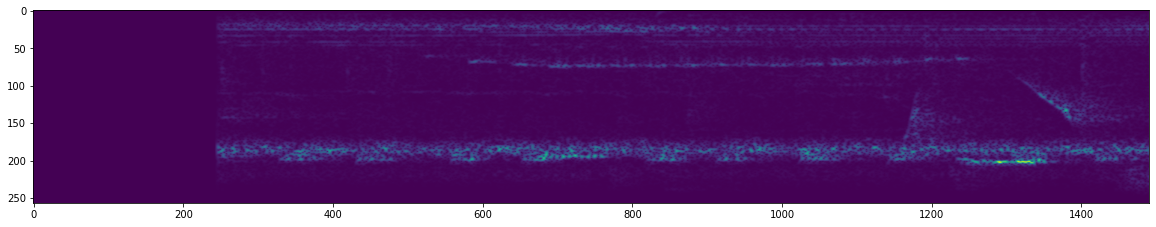

In [ ]:
plt.figure(figsize=(20,40))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

# 6. Create Training and Testing Partitions

## 6.1 Create a Tensorflow Data Pipeline

In [ ]:
#untill now we have writeen functions to display a file into its spectrogram
#now data has all the positive and negative files we want to convert it 
data = data.map(convert_to_spectro)
data = data.cache()

#shuffles or mixes the images of positive and negatives
data = data.shuffle(buffer_size=1000)

#batch of 16
data = data.batch(16)
#prefetch keeps the data for the next batch to process beforehand
data = data.prefetch(8)

## 6.2 Split into Training and Testing Partitions

In [ ]:
#taking 36 samples for training, data has 51 samples
train = data.take(36)
#15 samples for test
test = data.skip(36).take(15)

## 6.3 Test One Batch

In [ ]:
samples, labels = train.as_numpy_iterator().next()

In [ ]:
samples.shape

(16, 1491, 257, 1)

# 7. Build Deep Learning Model

## 7.1 Load Tensorflow Dependencies

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten

## 7.2 Build Sequential Model, Compile and View Summary

In [ ]:



model = tf.keras.models.Sequential([
     tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(1491, 257, 1)),
     tf.keras.layers.Conv2D(16, (3, 3), activation='relu'),
     tf.keras.layers.MaxPooling2D(2, 2),
     tf.keras.layers.Flatten(),
     tf.keras.layers.Dense(128, activation='relu'),
     tf.keras.layers.Dense(1, activation='sigmoid')
    
])

In [ ]:
model.compile('Adam', loss='BinaryCrossentropy', metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 1489, 255, 16)     160       
                                                                 
 conv2d_6 (Conv2D)           (None, 1487, 253, 16)     2320      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 743, 126, 16)     0         
 )                                                               
                                                                 
 flatten_2 (Flatten)         (None, 1497888)           0         
                                                                 
 dense_4 (Dense)             (None, 128)               191729792 
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                      

## 7.3 Fit Model, View Loss and KPI Plots

In [ ]:
hist = model.fit(train, epochs=4, validation_data=test)

Epoch 1/4
36/36 [==============================] - 262s 7s/step - loss: 1.9397 - recall_1: 0.8158 - precision_1: 0.7848 - val_loss: 0.1845 - val_recall_1: 0.7206 - val_precision_1: 0.9608
Epoch 2/4
36/36 [==============================] - 210s 6s/step - loss: 0.1179 - recall_1: 0.8543 - precision_1: 0.9847 - val_loss: 0.0520 - val_recall_1: 0.9851 - val_precision_1: 0.9565
Epoch 3/4
36/36 [==============================] - 183s 5s/step - loss: 0.0231 - recall_1: 0.9870 - precision_1: 0.9870 - val_loss: 0.0039 - val_recall_1: 1.0000 - val_precision_1: 1.0000
Epoch 4/4
36/36 [==============================] - 178s 5s/step - loss: 0.0038 - recall_1: 0.9936 - precision_1: 1.0000 - val_loss: 0.0044 - val_recall_1: 1.0000 - val_precision_1: 1.0000


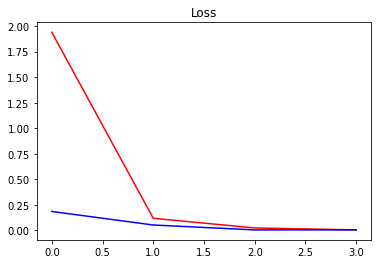

In [ ]:
plt.title('Loss')
plt.plot(hist.history['loss'], 'r')
plt.plot(hist.history['val_loss'], 'b')
plt.show()

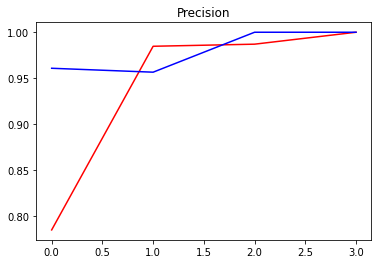

In [ ]:
plt.title('Precision')
plt.plot(hist.history['precision_1'], 'r')
plt.plot(hist.history['val_precision_1'], 'b')
plt.show()

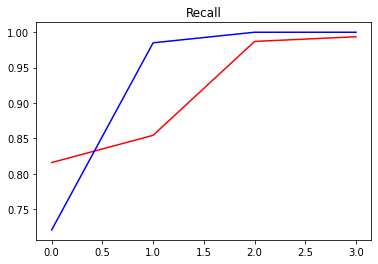

In [ ]:
plt.title('Recall')
plt.plot(hist.history['recall_1'], 'r')
plt.plot(hist.history['val_recall_1'], 'b')
plt.show()

# 8. Make a Prediction on a Single Clip

## 8.1 Get One Batch and Make a Prediction

In [ ]:
X_test_specto, y_test = test.as_numpy_iterator().next()

In [ ]:
yhat = model.predict(X_test_specto)

In [ ]:
import numpy as np
print(np.squeeze(yhat))

[6.0267150e-03 2.1583082e-16 3.6948919e-04 1.0000000e+00 8.9349860e-06
 1.0303456e-18 9.9364667e-22 1.6381427e-18 1.0000000e+00 1.2734480e-05
 6.8695843e-03 1.0000000e+00 2.5645704e-16 1.0000000e+00 0.0000000e+00
 1.0000000e+00]


## 8.2 Convert Logits to Classes 

In [ ]:
yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]
print(yhat,X_test)

[0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1] [[[[4.33784677e-04]
   [3.49517423e-03]
   [6.67650858e-03]
   ...
   [1.12459747e-04]
   [5.98151528e-05]
   [6.01226930e-05]]

  [[1.06090913e-03]
   [2.70797382e-03]
   [5.93086192e-03]
   ...
   [7.91475031e-05]
   [1.25544393e-04]
   [1.23645179e-04]]

  [[1.50872651e-03]
   [2.46674730e-03]
   [4.95533831e-03]
   ...
   [1.03266953e-04]
   [2.44736933e-04]
   [3.25445784e-04]]

  ...

  [[1.63891469e-03]
   [1.29160273e-03]
   [2.38251290e-04]
   ...
   [1.79752591e-04]
   [3.28597525e-05]
   [6.99271914e-05]]

  [[2.05327244e-03]
   [1.58483675e-03]
   [9.84113896e-04]
   ...
   [1.37255352e-04]
   [6.55299664e-05]
   [3.20948893e-05]]

  [[2.34991591e-03]
   [1.94939494e-03]
   [1.38421147e-03]
   ...
   [1.80887524e-04]
   [5.72294121e-05]
   [6.60516089e-05]]]


 [[[3.16597521e-04]
   [2.06384953e-04]
   [1.95691653e-04]
   ...
   [2.84175456e-07]
   [1.51819700e-06]
   [1.80210918e-06]]

  [[1.10374996e-04]
   [1.05710969e-04]

# 9. Build Forest Parsing Functions

## 9.1 Load up MP3s

In [ ]:
def loading_mp3_16khz_single(filename):
#   Loading a WAV file, converting it to a float tensor, resampling to 16 kHz single-channel audio. 
    res = tfio.audio.AudioIOTensor(filename)
    # Convert to tensor and combine channels 
    tensor = res.to_tensor()
    tensor = tf.math.reduce_sum(tensor, axis=1) / 2 
    # Extract sample rate and cast
    sample_rate = res.rate
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Resampling to 16 kHz
    wav = tfio.audio.resample(tensor, rate_in=sample_rate, rate_out=16000)
    return wav

In [ ]:
#telling the path on main data 
mp3_file = os.path.join('data', 'Forest Recordings', 'recording_00.mp3')

In [ ]:
#converted to 16khz
wav = loading_mp3_16khz_single(mp3_file)

In [ ]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)

In [ ]:
samples, index = audio_slices.as_numpy_iterator().next()

## 9.2 Build Function to Convert Clips into Windowed Spectrograms

In [ ]:
def preprocess_mp3(sample, index):
    sample = sample[0]
    zero_padding = tf.zeros([48000] - tf.shape(sample), dtype=tf.float32)
    wav = tf.concat([zero_padding, sample],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram

## 9.3 Convert Longer Clips into Windows and Make Predictions

In [ ]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=16000, sequence_stride=16000, batch_size=1)
audio_slices = audio_slices.map(preprocess_mp3)
audio_slices = audio_slices.batch(64)

In [ ]:
yhat = model.predict(audio_slices)
yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]

## 9.4 Group Consecutive Detections

In [ ]:
from itertools import groupby

In [ ]:
yhat = [key for key, group in groupby(yhat)]
calls = tf.math.reduce_sum(yhat).numpy()

In [ ]:
calls

# 10. Make Predictions

## 10.1 Loop over all recordings and make predictions

In [ ]:
results = {}
for file in os.listdir(os.path.join('data', 'Forest Recordings')):
    FILEPATH = os.path.join('data','Forest Recordings', file)
    
    wav = load_mp3_16k_mono(FILEPATH)
    audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)
    audio_slices = audio_slices.map(preprocess_mp3)
    audio_slices = audio_slices.batch(64)
    
    yhat = model.predict(audio_slices)
    
    results[file] = yhat

In [ ]:
results

## 10.2 Convert Predictions into Classes

In [ ]:
class_preds = {}
for file, logits in results.items():
    class_preds[file] = [1 if prediction > 0.99 else 0 for prediction in logits]
class_preds

## 10.3 Group Consecutive Detections

In [ ]:
postprocessed = {}
for file, scores in class_preds.items():
    postprocessed[file] = tf.math.reduce_sum([key for key, group in groupby(scores)]).numpy()
postprocessed

# 11. Export Results

In [ ]:
import csv

In [ ]:
with open('results.csv', 'w', newline='') as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerow(['recording', 'capuchin_calls'])
    for key, value in postprocessed.items():
        writer.writerow([key, value])